In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import sin, cos, sqrt, atan2, radians, degrees
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
train=pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
print('train shape :', train.shape)
print('test shape :',test.shape)

train shape : (1458644, 11)
test shape : (625134, 9)


- ID - 각 여행에 대한 고유 식별자
- vendor_id - 여행 기록과 관련된 공급자를 나타내는 코드
- pickup_datetime - 미터가 종사한 날짜 및 시간
- dropoff_datetime - 미터가 분리된 날짜 및 시간
- passenger_count - 차량의 승객 수 (운전자가 값을 입력)
- pickup_longitude - 미터가 종사하는 경도
- pickup_latitude - 미터가 종사하는 위도
- dropoff_longitude - 미터가 분리 된 경도
- dropoff_latitude - 미터가 분리 된 위도
- store_and_fwd_flag - 이 플래그는 차량이 서버에 연결되지 않았기 때문에 공급 업체에 보내기 전에 여행 기록이 차량 메모리에 보관되었는지 여부를 나타냅니다.-Y = 저장 및 전달; N = 저장 및 전진 여행 아님
- trip_duration - 초 여행의 기간

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
print('########### train ##################')
print(train.info())

print('########### test ##################')
print(test.info())

########### train ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
########### test ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data

In [6]:
print('############# train 결측치 ##############')
print(train.isnull().sum())

print('############# test 결측치 ##############')
print(test.isnull().sum())

############# train 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
############# test 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


- 결측치는 모든 데이터에 없다.

In [7]:
print('####################### train ##################')
display(train.describe())

print('###################### test ###################')
display(test.describe())

####################### train ##################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


###################### test ###################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [8]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# trip_duration을 target으로 바꿔준다.
train=train.rename(columns = {'trip_duration':'target'})

In [9]:
def sub_function(x):
    a=set(train[x].unique())
    b =set(test[x].unique())
    a =a.difference(test[x])
    b =b.difference(train[x])
    print(f'train_set 에만 있는 값 {a}')
    print(f'test_set 에만 있는 값 {b}')    

<AxesSubplot:xlabel='target', ylabel='Density'>

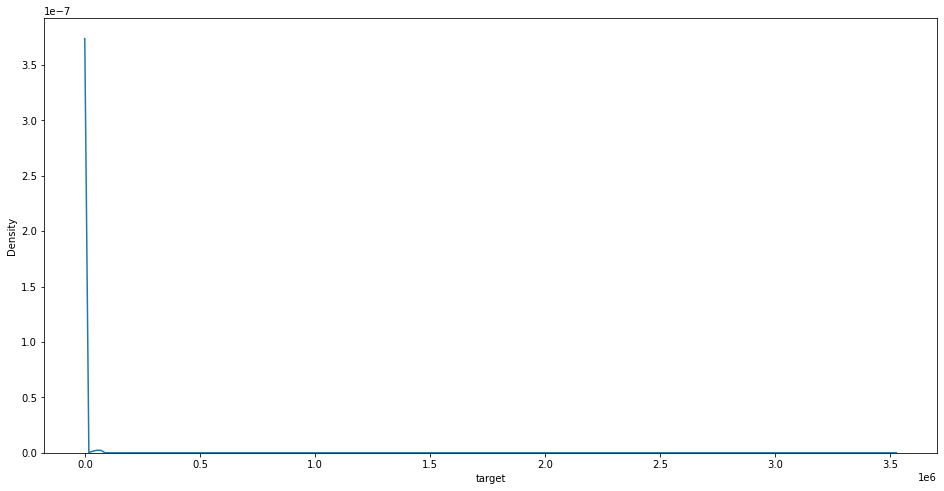

In [10]:
# target에 정규화를 시켜주고 분석을 진행해 주자.
plt.figure(figsize = (16,8))
sns.kdeplot(train['target'])

# id

In [11]:
train['id']=train['id'].apply(lambda x:x[2:])
train['id']=train['id'].astype('int')

test['id'] = test['id'].apply(lambda x: x[2:])
test['id'] = test['id'].astype('int')

In [12]:
train['id'].describe()

count    1.458644e+06
mean     1.999021e+06
std      1.154740e+06
min      1.000000e+00
25%      9.992588e+05
50%      1.998046e+06
75%      2.999228e+06
max      4.000000e+06
Name: id, dtype: float64

In [13]:
print(train['id'].min(), train['id'].max())
print(test['id'].min(), test['id'].max())

1 4000000
2 3999997


<AxesSubplot:xlabel='id', ylabel='Density'>

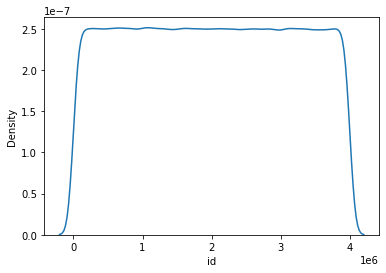

In [14]:
# 특정한 분포를 찾을 수 없으므로 이 데이터는 제거 해 주도록 하자.
sns.kdeplot(data = train, x = 'id')

## vendor_id

In [15]:
train.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

<AxesSubplot:xlabel='vendor_id', ylabel='target'>

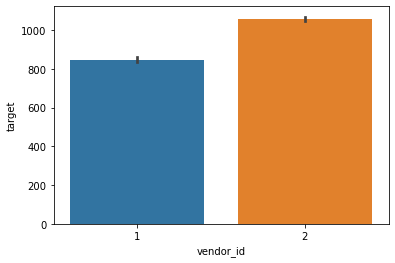

In [16]:
sns.barplot(data = train, x = 'vendor_id', y = 'target')

In [17]:
sub_function('vendor_id')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


- 이 데이터의 경우 설명도 나와 있지 않기 때문에 나중에 다른 변수와 비교할 때 사용해야 겠다.

## passenger_count

In [18]:
print('train의 passenger_count')
print(train['passenger_count'].value_counts())
print('test의 passenger_count')
print(test['passenger_count'].value_counts())

train의 passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64
test의 passenger_count
1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64


<AxesSubplot:xlabel='passenger_count', ylabel='target'>

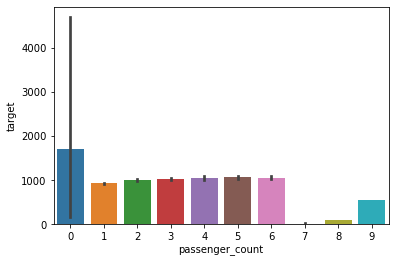

In [19]:
sns.barplot(data = train, x = 'passenger_count', y = 'target')

- 0명을 태웠다는 말은 무슨말일까?
- 일단 test셋에 7과 8이 없음으로 7과 8의 데이터를 지워주도록 하자!!

## pickup_datetime

In [20]:
def datetime(df, column):
    df['month'] = df[column].dt.month
    df['day'] = df[column].dt.day
    df['hour'] = df[column].dt.hour
    return df

In [21]:
train=datetime(df = train, column = 'pickup_datetime')
test=datetime(df = test, column = 'pickup_datetime')

In [22]:
# 주말과 평일을 나누어서 데이터를 분석해 보자.
train['weekday'] = train['pickup_datetime'].apply(lambda x:x.weekday())
train['weekday']=train['weekday'].apply(lambda x: 1 if x > 4 else 0)

test['weekday'] = test['pickup_datetime'].apply(lambda x:x.weekday())
test['weekday']=test['weekday'].apply(lambda x: 1 if x > 4 else 0)

### 평일과 공휴일의 차이

Text(0.5, 1.0, 'weekday vs target')

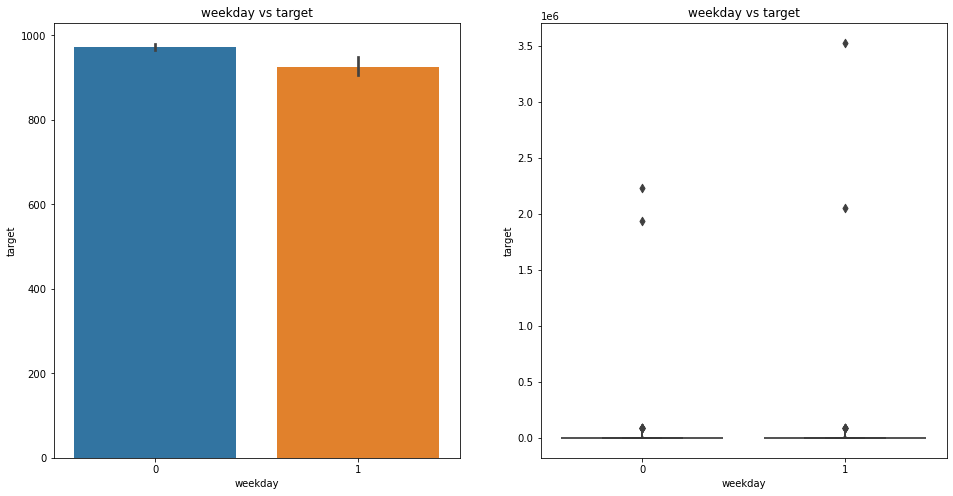

In [23]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('weekday vs target')

sns.boxenplot(data = train, x = 'weekday', y = 'target', ax = ax[1])
ax[1].set_title('weekday vs target')

- 사람들은 평일에 택시를 더 많이 타는 것을 알 수있다.

### 월별로 차이

Text(0.5, 1.0, 'month vs target')

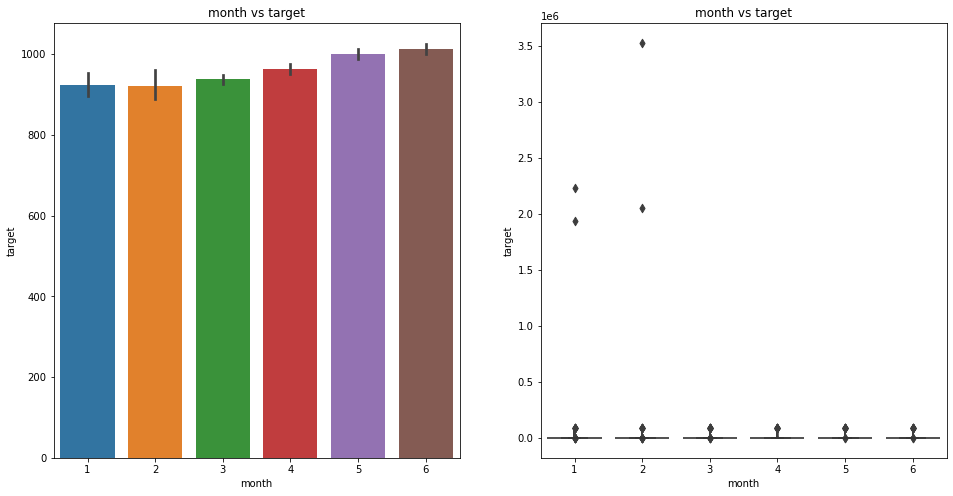

In [24]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('month vs target')

sns.boxenplot(data = train, x = 'month', y = 'target', ax = ax[1])
ax[1].set_title('month vs target')

- 매 달마다 택시를 타는 사람이 늘어나고 있다.

In [25]:
sub_function('month')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


### 일별로 차이

<AxesSubplot:xlabel='day', ylabel='target'>

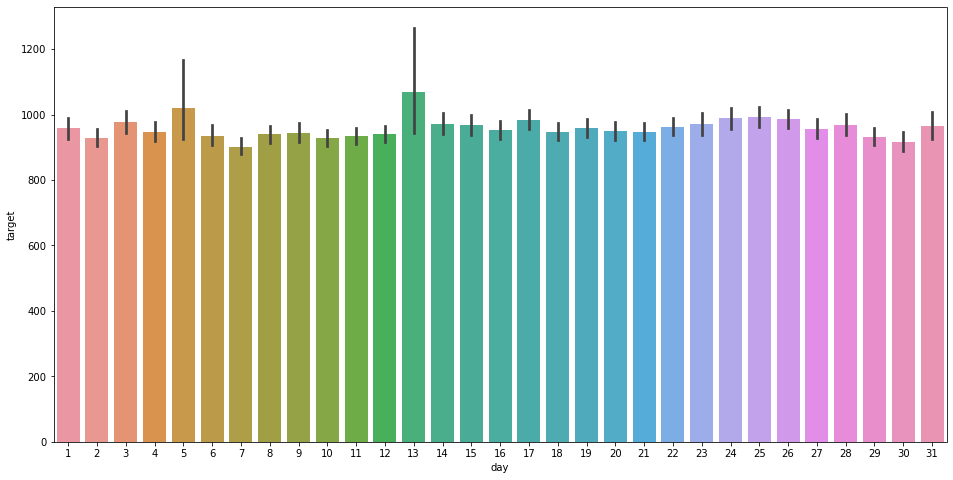

In [26]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target')

- 일별로는 다른 차이점을 발견하지 못했다.

In [27]:
sub_function('day')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


<AxesSubplot:xlabel='hour', ylabel='target'>

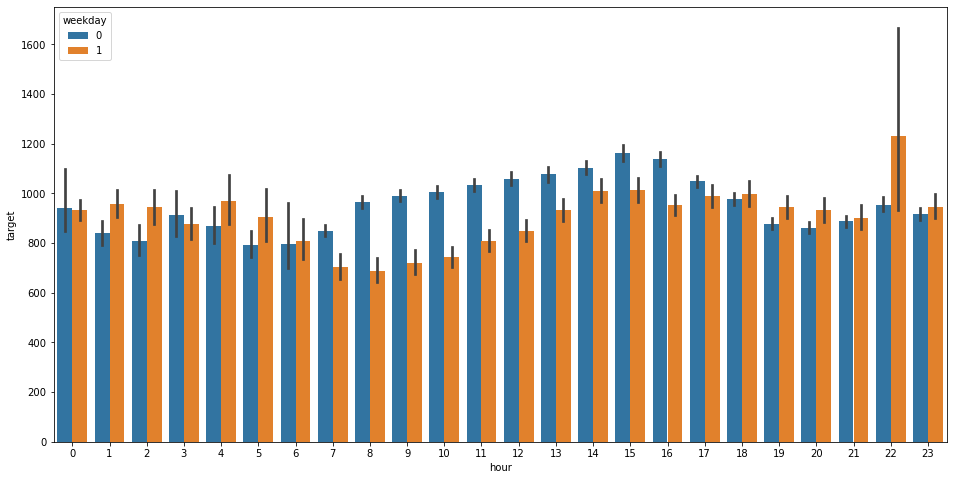

In [28]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')

- 시간별로 공휴일인지 아닌지는 차이가 있는 것 같다.

## 위도 경도를 이용해 거리 구하기

In [29]:
!pip install haversine

In [30]:
from haversine import haversine

In [31]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [32]:
def haversine1(lat1, lon1, lat2, lon2, R = 6373.0):
    
    R = R # 'km'를 나타내기위해 수를 지정해준다.
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1)*cos(lat2)*sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    distance = R * c
    return distance
    
train['distance'] = train.apply(lambda x:haversine1(x['pickup_latitude'],
                                                   x['pickup_longitude'],
                                                   x['dropoff_latitude'],
                                                   x['dropoff_longitude']
                                                   ), axis = 1)

test['distance'] = test.apply(lambda x:haversine1(x['pickup_latitude'],
                                                   x['pickup_longitude'],
                                                   x['dropoff_latitude'],
                                                   x['dropoff_longitude']
                                                   ), axis = 1)

In [33]:
# haversine을 짯지만 너무 느린관계로 쓰지 않는다.
# from tqdm import tqdm

# def haversine1(df = None):
#     for i in tqdm(df.index):
#         df.loc[i,'distance'] = haversine((df.loc[i,'pickup_longitude'],df.loc[i,'pickup_latitude']),
#                                          (df.loc[i,'dropoff_longitude'],df.loc[i,'dropoff_latitude']), unit = 'm')
#     return df

# distance_train=haversine1(df = train)
# distance_train=pd.DataFrame(distance_train)

# distance_test = haversine1(df = test)
# distance_test = pd.DataFrame(distance_test)

In [34]:
# 상관관계는 0.1도 안되는걸 확인했다.
train[['distance','target']].corr()

,distance,target
distance,1.000000,0.094777
target,0.094777,1.000000


<AxesSubplot:xlabel='distance', ylabel='Density'>

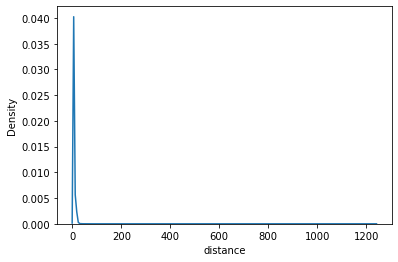

In [35]:
# 그래프를 그려봤을 때 0에 몰려있는 것을 확인했다.
# 로그를 이용해서 정규화를 시켜주자.
sns.kdeplot(data = train, x = 'distance')

In [36]:
# 로그화 작업
train['distance'] = train['distance'].apply(lambda x: np.log1p(x))
test['distance'] = test['distance'].apply(lambda x:np.log1p(x))

## 평균 속도로 군집화 해주기

In [37]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,target,month,day,hour,weekday,distance
0,2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17,0,0.915887
1,2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0,1,1.031786
2,3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11,0,1.999736
3,3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19,0,0.910661
4,2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13,1,0.783427


In [38]:
# def average_speed(df = None):
#   df['time_hour'] = df['target'].apply(lambda x: x/3600)
#   for i in df.index:
#     df.loc[i,'averge_speed'] = df.loc[i,'distance']/df.loc[i,'time_hour']
#   return df


# train = average_speed(train)

In [39]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'month', 'day', 'hour', 'weekday', 'distance'],
      dtype='object')

In [40]:
# KMeans 불러오기
from sklearn.cluster import MiniBatchKMeans

# k-means clustering 실행
# pickup
kmeans = MiniBatchKMeans( n_clusters = 20, batch_size = 500)
kmeans.fit(train[['pickup_latitude','pickup_longitude']])
train['pickup_clustring']= kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test['pickup_clustring'] = kmeans.predict(test[['pickup_latitude','pickup_longitude']])

# dropoff
kmeans = MiniBatchKMeans(n_clusters = 20, batch_size = 500)
kmeans.fit(train[['dropoff_latitude','dropoff_longitude']])
train['dropoff_clustring']= kmeans.predict(train[['dropoff_latitude','dropoff_longitude']])
test['dropoff_clustring'] = kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

## store_and_fwd_flag

In [41]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='target'>

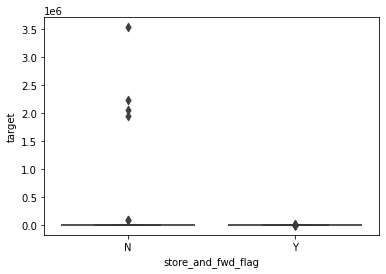

In [42]:
sns.boxenplot(data = train, x = 'store_and_fwd_flag', y = 'target')

- Y가 N보다 더 높은 시간은 나타낸다.

In [43]:
sub_function('store_and_fwd_flag')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='target'>

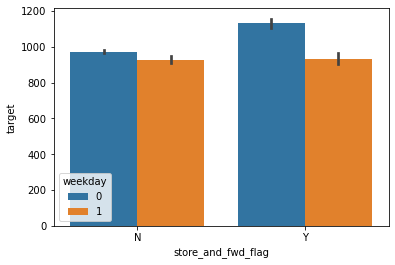

In [44]:
sns.barplot(data = train, x = 'store_and_fwd_flag', y = 'target', hue = 'weekday')

<AxesSubplot:>

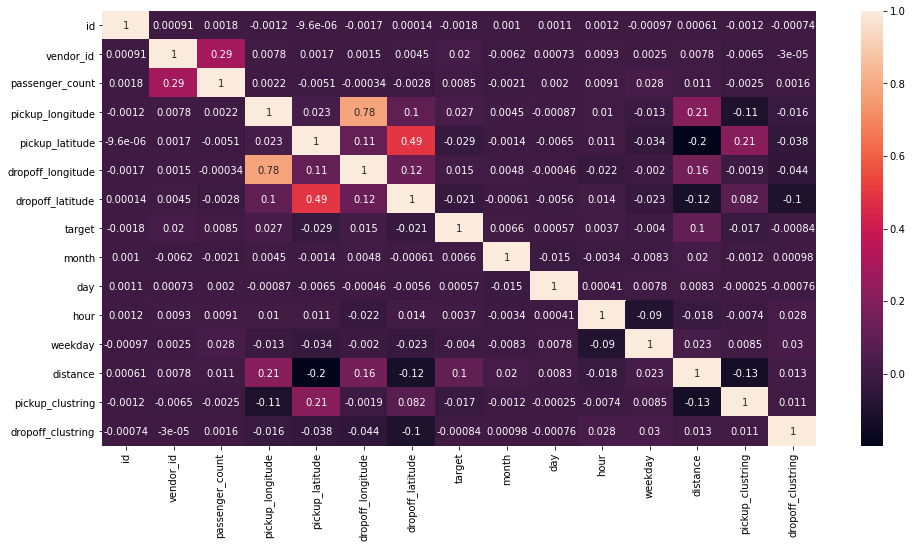

In [45]:
plt.figure(figsize = (16,8))
train_corr=train.corr()
sns.heatmap(train_corr, annot = True)

In [46]:
print('-------- train ----------')
print(train['distance'].describe())
print('------------ test -----------')
print(test['distance'].describe())

-------- train ----------
count    1.458644e+06
mean     1.254794e+00
std      6.272036e-01
min      0.000000e+00
25%      8.029981e-01
50%      1.129586e+00
75%      1.584439e+00
max      7.124718e+00
Name: distance, dtype: float64
------------ test -----------
count    625134.000000
mean          1.254233
std           0.626017
min           0.000000
25%           0.803040
50%           1.129592
75%           1.585919
max           6.944443
Name: distance, dtype: float64


In [47]:
# 그래서 거리의 사분위수를 이용해 나눠주기로 하자.
train['distance'].describe()

train.loc[train['distance'] <= 0.8029981 , 'distance_binning'] = 0
train.loc[(train['distance'] >=0.8029981) & (train['distance'] < 1.129586), 'distance_binning'] = 1
train.loc[(train['distance'] >= 1.129586) & (train['distance'] < 1.584439 ), 'distance_binning'] = 2
train.loc[train['distance'] >= 1.584439, 'distance_binning'] = 3

test.loc[test['distance'] <= 0.803040 , 'distance_binning'] = 0
test.loc[(test['distance'] >= 0.803040) & (test['distance'] < 1.129592), 'distance_binning'] = 1
test.loc[(test['distance'] >= 1.129592) & (test['distance'] < 1.585919 ), 'distance_binning'] = 2
test.loc[test['distance'] >= 1.585919, 'distance_binning'] = 3

In [48]:
# sns.barplot(data = train, x = 'distance_binning', y = 'target')

- 변수마다 연관이 있는 걸로 보여진다.

In [49]:
delete_index=train[(train['passenger_count'] == 7)|(train['passenger_count'] == 8)].index
train=train.drop(delete_index,axis = 0)

sub_function('passenger_count')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


<AxesSubplot:xlabel='hour', ylabel='distance'>

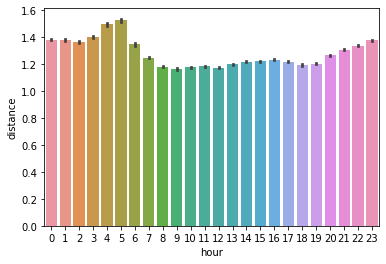

In [50]:
# 3~5시 사이에 높은 이동량을 보인다.
sns.barplot(data = train, x = 'hour', y = 'distance')

<AxesSubplot:xlabel='month', ylabel='distance'>

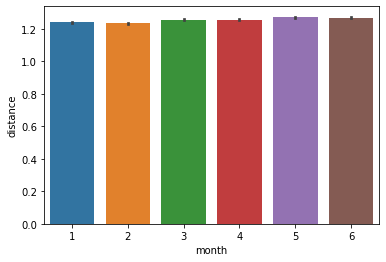

In [51]:
# 눈이 오거나 안오거나에 따라서 거리에 차이가 있을 것 같다.
sns.barplot(data = train, x = 'month', y = 'distance')

# 즉, 눈이 올 시기인 1~2월에는 차들이 좀 더 서행운전을 하기 때문에 목적지에 더 늦게 도착할 것 같다.

### 가정 1 : 날씨가 추운 1~2월은 적은 거리도 추운 날씨 때문에 택시를 탈 것이다.

![%EC%BA%A1%EC%B2%98.PNG](attachment:%EC%BA%A1%EC%B2%98.PNG)

- 변수 0 :1~2월은 겨울인 달
- 변수 1 :3~6월은 겨울이 아닌 달

In [52]:
# 겨울인 1~2월에는 사람들이 적은 거리도 택시를 탈 것이다.
train['cold'] = 1
train.loc[(train['month'] == 1) | (train['month'] == 2), 'cold'] = 0

test['cold'] = 1
test.loc[(test['month'] == 1) | (test['month'] == 2), 'cold'] = 0

In [53]:
train.cold.value_counts()

1    990634
0    468006
Name: cold, dtype: int64

<AxesSubplot:xlabel='cold', ylabel='target'>

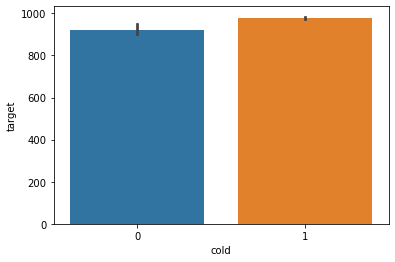

In [54]:
sns.barplot(data = train, x = 'cold', y = 'target')

### 가정 2 :  평일의 일하는 시간대, 일하지 않는 시간대, 주말 이렇게 비교해보도록 하자.
### 2. 일하는 시간대에 사람들이 가장 많이 활동하는 시간대 임으로 도로상황을 고려하여 차를 오래 탄다고 생각한다.
### 1. 주말에 놀러 나가는 사람들이 많으나 일하는 시간대에 비해 차가 안막힌다고 가정한다.
### 0. 평일 일하지 않는 시간대에는 차가 막히지 않으므로 택시를 타고 있는 시간이 적다고 가정했다.

<AxesSubplot:xlabel='hour', ylabel='target'>

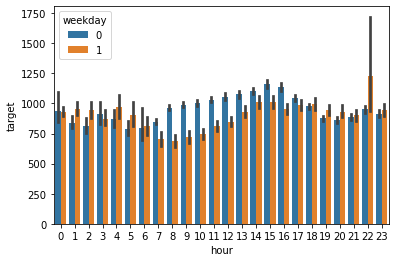

In [55]:
sns.barplot(data = train, x=  'hour', y = 'target', hue = 'weekday')

In [56]:
train.loc[(train['weekday'] == 0), 'working'] = 0
train.loc[train['weekday'] == 1,'working'] = 1
train.loc[(train['weekday'] == 0) & (8 <= train['hour']) & (train['hour'] <= 18), 'working'] = 2

test.loc[(test['weekday'] == 0), 'working'] = 0
test.loc[test['weekday'] == 1,'working'] = 1
test.loc[(test['weekday'] == 0) & (8 <= test['hour']) & (test['hour'] <= 18), 'working'] = 2

<AxesSubplot:xlabel='working', ylabel='target'>

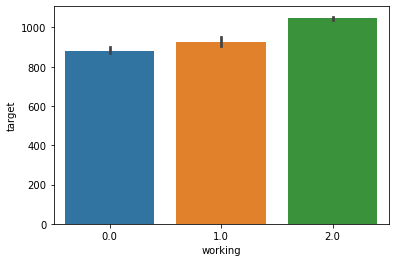

In [57]:
sns.barplot(data = train, x = 'working', y = 'target')

- 유의미한 변수가 될 것 같다.
- 이 변수는 더미화를 시켜주지 않고 넣어주도록 하자.

## 모델링

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [59]:
dummies=['vendor_id','store_and_fwd_flag','month','hour','weekday','passenger_count','pickup_clustring','dropoff_clustring','cold','working']
# train 데이터 더미화
data = pd.get_dummies(data = train[dummies], columns = dummies)
train_data = data.copy()

# test 데이터 더미화
test_dummies=pd.get_dummies(test[dummies], columns = dummies)
test_data = test_dummies

In [60]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


In [62]:
# 평가지표는 rmsle를 사용한다.
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

- rmsle를 사용하여 좋은 모델을 골라주고 파라미터를 수정한다.

In [67]:
# 정규분포를 예측하기 위해서 target에 log를 취해준다.
train['target'] = train['target'].apply(lambda x:np.log1p(x))

In [ ]:
# xgbregressor를 수행해준다.
xgb = XGBRegressor(objective='reg:linear', n_estimators=150, subsample=0.75)
xgb.fit(train_data, train['target'])
y_pred = xgb.predict(test_data)

# 예측값을 로그 씌우기 전으로 바꿔준다.
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)


# submission에 저장하여 제출한다.
submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)

[19:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# 0.47924
submission

In [76]:
# catboostregressor를 수행해준다.
cat = CatBoostRegressor(iterations=150)
cat.fit(train_data, train['target'])
y_pred = cat.predict(test_data)

# 예측값을 로그 씌우기 전으로 바꿔준다.
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# submission에 저장하여 제출한다.
submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)

Learning rate set to 0.142752
0:	learn: 0.7335986	total: 178ms	remaining: 2m 58s
1:	learn: 0.6842557	total: 354ms	remaining: 2m 56s
2:	learn: 0.6452983	total: 574ms	remaining: 3m 10s
3:	learn: 0.6150995	total: 777ms	remaining: 3m 13s
4:	learn: 0.5917774	total: 953ms	remaining: 3m 9s
5:	learn: 0.5737175	total: 1.12s	remaining: 3m 5s
6:	learn: 0.5600316	total: 1.32s	remaining: 3m 6s
7:	learn: 0.5493577	total: 1.51s	remaining: 3m 7s
8:	learn: 0.5413181	total: 1.7s	remaining: 3m 7s
9:	learn: 0.5350598	total: 1.88s	remaining: 3m 5s
10:	learn: 0.5300679	total: 2.04s	remaining: 3m 3s
11:	learn: 0.5262493	total: 2.22s	remaining: 3m 2s
12:	learn: 0.5232076	total: 2.37s	remaining: 3m
13:	learn: 0.5206678	total: 2.54s	remaining: 2m 59s
14:	learn: 0.5183683	total: 2.71s	remaining: 2m 57s
15:	learn: 0.5166328	total: 2.87s	remaining: 2m 56s
16:	learn: 0.5148998	total: 3.02s	remaining: 2m 54s
17:	learn: 0.5136338	total: 3.17s	remaining: 2m 53s
18:	learn: 0.5125558	total: 3.34s	remaining: 2m 52s
19:	l

158:	learn: 0.4805567	total: 26s	remaining: 2m 17s
159:	learn: 0.4804960	total: 26.2s	remaining: 2m 17s
160:	learn: 0.4803540	total: 26.3s	remaining: 2m 17s
161:	learn: 0.4802792	total: 26.5s	remaining: 2m 16s
162:	learn: 0.4802129	total: 26.6s	remaining: 2m 16s
163:	learn: 0.4801444	total: 26.8s	remaining: 2m 16s
164:	learn: 0.4800643	total: 26.9s	remaining: 2m 16s
165:	learn: 0.4799639	total: 27.1s	remaining: 2m 16s
166:	learn: 0.4798906	total: 27.3s	remaining: 2m 15s
167:	learn: 0.4798245	total: 27.4s	remaining: 2m 15s
168:	learn: 0.4797804	total: 27.6s	remaining: 2m 15s
169:	learn: 0.4797417	total: 27.7s	remaining: 2m 15s
170:	learn: 0.4796658	total: 27.9s	remaining: 2m 15s
171:	learn: 0.4795825	total: 28s	remaining: 2m 14s
172:	learn: 0.4795288	total: 28.2s	remaining: 2m 14s
173:	learn: 0.4794710	total: 28.3s	remaining: 2m 14s
174:	learn: 0.4794181	total: 28.5s	remaining: 2m 14s
175:	learn: 0.4793397	total: 28.7s	remaining: 2m 14s
176:	learn: 0.4793016	total: 28.8s	remaining: 2m 1

316:	learn: 0.4734547	total: 50.8s	remaining: 1m 49s
317:	learn: 0.4734349	total: 51s	remaining: 1m 49s
318:	learn: 0.4734099	total: 51.1s	remaining: 1m 49s
319:	learn: 0.4733844	total: 51.3s	remaining: 1m 49s
320:	learn: 0.4733592	total: 51.5s	remaining: 1m 48s
321:	learn: 0.4733426	total: 51.6s	remaining: 1m 48s
322:	learn: 0.4733110	total: 51.7s	remaining: 1m 48s
323:	learn: 0.4732887	total: 51.9s	remaining: 1m 48s
324:	learn: 0.4732674	total: 52s	remaining: 1m 48s
325:	learn: 0.4732336	total: 52.2s	remaining: 1m 47s
326:	learn: 0.4732134	total: 52.4s	remaining: 1m 47s
327:	learn: 0.4731891	total: 52.5s	remaining: 1m 47s
328:	learn: 0.4731511	total: 52.7s	remaining: 1m 47s
329:	learn: 0.4731314	total: 52.8s	remaining: 1m 47s
330:	learn: 0.4731070	total: 53s	remaining: 1m 47s
331:	learn: 0.4730900	total: 53.1s	remaining: 1m 46s
332:	learn: 0.4730678	total: 53.3s	remaining: 1m 46s
333:	learn: 0.4730515	total: 53.4s	remaining: 1m 46s
334:	learn: 0.4730245	total: 53.6s	remaining: 1m 46s

472:	learn: 0.4704647	total: 1m 14s	remaining: 1m 22s
473:	learn: 0.4704497	total: 1m 14s	remaining: 1m 22s
474:	learn: 0.4704366	total: 1m 14s	remaining: 1m 22s
475:	learn: 0.4704205	total: 1m 14s	remaining: 1m 22s
476:	learn: 0.4704079	total: 1m 14s	remaining: 1m 22s
477:	learn: 0.4703953	total: 1m 15s	remaining: 1m 21s
478:	learn: 0.4703844	total: 1m 15s	remaining: 1m 21s
479:	learn: 0.4703743	total: 1m 15s	remaining: 1m 21s
480:	learn: 0.4703595	total: 1m 15s	remaining: 1m 21s
481:	learn: 0.4703403	total: 1m 15s	remaining: 1m 21s
482:	learn: 0.4703279	total: 1m 15s	remaining: 1m 21s
483:	learn: 0.4703146	total: 1m 15s	remaining: 1m 21s
484:	learn: 0.4702956	total: 1m 16s	remaining: 1m 20s
485:	learn: 0.4702832	total: 1m 16s	remaining: 1m 20s
486:	learn: 0.4702673	total: 1m 16s	remaining: 1m 20s
487:	learn: 0.4702566	total: 1m 16s	remaining: 1m 20s
488:	learn: 0.4702456	total: 1m 16s	remaining: 1m 20s
489:	learn: 0.4702319	total: 1m 16s	remaining: 1m 20s
490:	learn: 0.4702193	total:

626:	learn: 0.4687029	total: 1m 37s	remaining: 58.1s
627:	learn: 0.4686951	total: 1m 37s	remaining: 57.9s
628:	learn: 0.4686793	total: 1m 37s	remaining: 57.7s
629:	learn: 0.4686712	total: 1m 38s	remaining: 57.6s
630:	learn: 0.4686608	total: 1m 38s	remaining: 57.4s
631:	learn: 0.4686551	total: 1m 38s	remaining: 57.3s
632:	learn: 0.4686470	total: 1m 38s	remaining: 57.1s
633:	learn: 0.4686419	total: 1m 38s	remaining: 56.9s
634:	learn: 0.4686321	total: 1m 38s	remaining: 56.8s
635:	learn: 0.4686227	total: 1m 38s	remaining: 56.6s
636:	learn: 0.4686126	total: 1m 39s	remaining: 56.5s
637:	learn: 0.4686060	total: 1m 39s	remaining: 56.3s
638:	learn: 0.4685989	total: 1m 39s	remaining: 56.2s
639:	learn: 0.4685900	total: 1m 39s	remaining: 56s
640:	learn: 0.4685835	total: 1m 39s	remaining: 55.8s
641:	learn: 0.4685774	total: 1m 39s	remaining: 55.7s
642:	learn: 0.4685680	total: 1m 40s	remaining: 55.5s
643:	learn: 0.4685609	total: 1m 40s	remaining: 55.4s
644:	learn: 0.4685499	total: 1m 40s	remaining: 5

782:	learn: 0.4675798	total: 2m 1s	remaining: 33.7s
783:	learn: 0.4675726	total: 2m 1s	remaining: 33.5s
784:	learn: 0.4675691	total: 2m 1s	remaining: 33.3s
785:	learn: 0.4675645	total: 2m 1s	remaining: 33.2s
786:	learn: 0.4675547	total: 2m 2s	remaining: 33s
787:	learn: 0.4675489	total: 2m 2s	remaining: 32.9s
788:	learn: 0.4675444	total: 2m 2s	remaining: 32.7s
789:	learn: 0.4675376	total: 2m 2s	remaining: 32.6s
790:	learn: 0.4675322	total: 2m 2s	remaining: 32.4s
791:	learn: 0.4675273	total: 2m 2s	remaining: 32.3s
792:	learn: 0.4675226	total: 2m 2s	remaining: 32.1s
793:	learn: 0.4675155	total: 2m 3s	remaining: 31.9s
794:	learn: 0.4675085	total: 2m 3s	remaining: 31.8s
795:	learn: 0.4675013	total: 2m 3s	remaining: 31.6s
796:	learn: 0.4674965	total: 2m 3s	remaining: 31.5s
797:	learn: 0.4674904	total: 2m 3s	remaining: 31.3s
798:	learn: 0.4674823	total: 2m 3s	remaining: 31.2s
799:	learn: 0.4674765	total: 2m 4s	remaining: 31s
800:	learn: 0.4674700	total: 2m 4s	remaining: 30.9s
801:	learn: 0.46

940:	learn: 0.4667487	total: 2m 25s	remaining: 9.14s
941:	learn: 0.4667440	total: 2m 25s	remaining: 8.99s
942:	learn: 0.4667410	total: 2m 26s	remaining: 8.83s
943:	learn: 0.4667336	total: 2m 26s	remaining: 8.68s
944:	learn: 0.4667275	total: 2m 26s	remaining: 8.52s
945:	learn: 0.4667194	total: 2m 26s	remaining: 8.37s
946:	learn: 0.4667151	total: 2m 26s	remaining: 8.21s
947:	learn: 0.4667104	total: 2m 26s	remaining: 8.06s
948:	learn: 0.4667063	total: 2m 27s	remaining: 7.9s
949:	learn: 0.4667006	total: 2m 27s	remaining: 7.75s
950:	learn: 0.4666952	total: 2m 27s	remaining: 7.6s
951:	learn: 0.4666884	total: 2m 27s	remaining: 7.44s
952:	learn: 0.4666843	total: 2m 27s	remaining: 7.29s
953:	learn: 0.4666819	total: 2m 27s	remaining: 7.13s
954:	learn: 0.4666775	total: 2m 28s	remaining: 6.98s
955:	learn: 0.4666738	total: 2m 28s	remaining: 6.82s
956:	learn: 0.4666719	total: 2m 28s	remaining: 6.67s
957:	learn: 0.4666670	total: 2m 28s	remaining: 6.51s
958:	learn: 0.4666626	total: 2m 28s	remaining: 6

In [77]:
submission

,id,trip_duration
0,id3004672,795.119278
1,id3505355,660.050861
2,id1217141,534.688209
3,id2150126,931.133776
4,id1598245,241.015615
...,...,...
625129,id3008929,212.820846
625130,id3700764,1149.132516
625131,id2568735,1302.462334
625132,id1384355,1518.996417


In [80]:
# LGBMRegressor를 수행해준다.
lgb = LGBMRegressor()
lgb.fit(train_data, train['target'])
y_pred = cat.predict(test_data)

# 예측값을 로그 씌우기 전으로 바꿔준다.
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# submission에 저장하여 제출한다.
submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)

In [81]:
submission

,id,trip_duration
0,id3004672,795.119278
1,id3505355,660.050861
2,id1217141,534.688209
3,id2150126,931.133776
4,id1598245,241.015615
...,...,...
625129,id3008929,212.820846
625130,id3700764,1149.132516
625131,id2568735,1302.462334
625132,id1384355,1518.996417


In [82]:
# RandomForestRegressor를 수행해준다.
rfg = RandomForestRegressor(n_estimators=25, min_samples_leaf=25, min_samples_split=25)
rfg.fit(train_data, train['target'])
y_pred = cat.predict(test_data)

# 예측값을 로그 씌우기 전으로 바꿔준다.
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# submission에 저장하여 제출한다.
submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)

KeyboardInterrupt: 

In [ ]:
submission